In [1]:
!pip install transformers datasets torch scikit-learn

In [2]:
from datasets import load_dataset

# Load the GoEmotions dataset from Hugging Face datasets hub
dataset = load_dataset("go_emotions")
# 'dataset' contains 'train', 'validation', and 'test' splits


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [3]:
# Each example contains 'text' and a list of emotion labels
print(dataset["train"])
# Output example: {'text': 'I love this!', 'labels': [8, 13]}

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 43410
})


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use a BERT-base model for multi-label classification (28 emotions)
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=28,
    problem_type="multi_label_classification"
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Map tokenization over dataset
encoded_dataset = dataset.map(tokenize_batch, batched=True)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [6]:
import numpy as np

def format_labels(batch):
    # Convert list of label indices into multi-hot vectors for multilabel
    multi_hot = np.zeros(28)
    for label in batch["labels"]:
        multi_hot[label] = 1
    batch["label"] = multi_hot
    return batch

# Map formatting over splits
encoded_dataset = encoded_dataset.map(format_labels)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [7]:
from torch.utils.data import DataLoader
import torch

# Define PyTorch dataset
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.input_ids = torch.tensor(data['input_ids'])
        self.attention_mask = torch.tensor(data['attention_mask'])
        self.labels = torch.tensor(data['label'])
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }
    def __len__(self):
        return len(self.labels)

train_data = EmotionDataset(encoded_dataset['train'])
val_data = EmotionDataset(encoded_dataset['validation'])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)


In [8]:
# Define the device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device
model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):  # Number of epochs
    model.train()
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Print progress every 50 batches
        if step % 50 == 0:
            print(f"Epoch {epoch} - Batch {step} - Training Loss: {loss.item():.4f}")

    # Optionally print loss at epoch end as well
    print(f"Epoch {epoch} completed. Last batch Loss: {loss.item():.4f}")


Epoch 0 - Batch 0 - Training Loss: 0.6615
Epoch 0 - Batch 50 - Training Loss: 0.3003
Epoch 0 - Batch 100 - Training Loss: 0.1884
Epoch 0 - Batch 150 - Training Loss: 0.1890
Epoch 0 - Batch 200 - Training Loss: 0.1461
Epoch 0 - Batch 250 - Training Loss: 0.1596
Epoch 0 - Batch 300 - Training Loss: 0.1430
Epoch 0 - Batch 350 - Training Loss: 0.1386
Epoch 0 - Batch 400 - Training Loss: 0.1253
Epoch 0 - Batch 450 - Training Loss: 0.1331
Epoch 0 - Batch 500 - Training Loss: 0.1472
Epoch 0 - Batch 550 - Training Loss: 0.1098
Epoch 0 - Batch 600 - Training Loss: 0.1460
Epoch 0 - Batch 650 - Training Loss: 0.1103
Epoch 0 - Batch 700 - Training Loss: 0.1227
Epoch 0 - Batch 750 - Training Loss: 0.1553
Epoch 0 - Batch 800 - Training Loss: 0.1275
Epoch 0 - Batch 850 - Training Loss: 0.1188
Epoch 0 - Batch 900 - Training Loss: 0.1091
Epoch 0 - Batch 950 - Training Loss: 0.1172
Epoch 0 - Batch 1000 - Training Loss: 0.1145
Epoch 0 - Batch 1050 - Training Loss: 0.1269
Epoch 0 - Batch 1100 - Training L

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
import torch

model.eval()
all_preds = []
all_labels = []

start_time = time.time()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = torch.sigmoid(outputs.logits)
        all_preds.append(logits.cpu())
        all_labels.append(labels.cpu())

end_time = time.time()

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Binarize predictions at threshold 0.5
preds_bin = all_preds > 0.5

# Calculate multilabel metrics (micro averaging)
precision = precision_score(all_labels, preds_bin, average="micro")
recall = recall_score(all_labels, preds_bin, average="micro")
f1 = f1_score(all_labels, preds_bin, average="micro")

# For multi-label, accuracy can be defined as average exact match ratio:
accuracy = (preds_bin == all_labels).all(axis=1).mean()

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Exact Match Accuracy: {accuracy:.4f}")
print(f"Evaluation runtime: {end_time - start_time:.2f} seconds")


Precision: 0.6910
Recall:    0.4914
F1 Score:  0.5743
Exact Match Accuracy: 0.4598
Evaluation runtime: 36.34 seconds


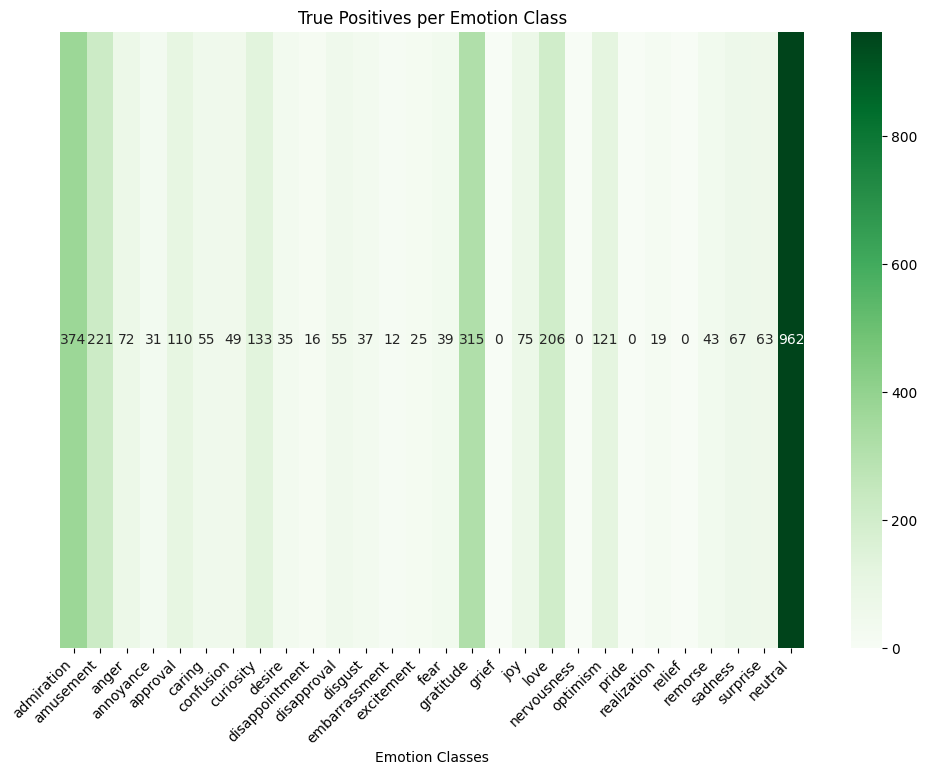

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# all_labels and preds_bin are numpy arrays of shape (num_samples, num_classes) with binary values (0 or 1)
num_classes = all_labels.shape[1]
confusion_matrices = np.zeros((num_classes, 2, 2), dtype=int)

for i in range(num_classes):
    # Compute confusion matrix for i-th class
    cm = confusion_matrix(all_labels[:, i], preds_bin[:, i], labels=[0,1])
    confusion_matrices[i] = cm

# To visualize, you can create a summary matrix, e.g., True Positives, False Positives per class
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
fn = confusion_matrices[:, 1, 0]
tn = confusion_matrices[:, 0, 0]

# Example: Create a heatmap of True Positives per class
emotions = [  # List of emotion labels (28 classes)
    'admiration', 'amusement', 'anger', 'annoyance', 'approval',
    'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
    'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness',
    'optimism', 'pride', 'realization', 'relief', 'remorse',
    'sadness', 'surprise', 'neutral'
]

plt.figure(figsize=(12, 8))
sns.heatmap(tp.reshape(1, -1), annot=True, fmt='d', cmap='Greens', xticklabels=emotions)
plt.title('True Positives per Emotion Class')
plt.xlabel('Emotion Classes')
plt.yticks([])
plt.xticks(rotation=45, ha='right')
plt.show()
